In [8]:
!pip install astropy

In [26]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import os

# Define the directory containing the FITS files
directory_path = '/content/comets2'

# List all FITS files in the directory
fits_files = [f for f in os.listdir(directory_path) if f.endswith('.fits')]
print(f"Found {len(fits_files)} FITS files.")


Found 9 FITS files.


In [30]:
def process_fits(fits_file):
    with fits.open(fits_file) as hdul:
        image_data = hdul[0].data

    plt.imshow(image_data, cmap='gray')
    plt.colorbar()
    plt.title(f'Original Comet Image: {fits_file}')
    plt.show()

    # Calculate the centroid using the weighted average method
    total_intensity = np.sum(image_data)
    i_indices, j_indices = np.meshgrid(np.arange(image_data.shape[0]), np.arange(image_data.shape[1]), indexing='ij')
    x0 = np.sum(i_indices * image_data) / total_intensity
    y0 = np.sum(j_indices * image_data) / total_intensity
    I0 = image_data[int(round(x0)), int(round(y0))]

    print(f"--------------------------------------------")
    print(f"Centroid: ({x0:.2f}, {y0:.2f}), Peak Intensity: {I0}")
    print(f"--------------------------------------------")

    i, j = np.meshgrid(np.arange(image_data.shape[0]), np.arange(image_data.shape[1]), indexing='ij')
    rho = np.sqrt((i - x0)**2 + (j - y0)**2)
    theta = np.arctan2(j - y0, i - x0) * 360 / (2 * np.pi)

    T1 = np.column_stack((i.ravel(), j.ravel(), rho.ravel(), theta.ravel(), image_data.ravel()))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(rho, cmap='viridis')
    ax[0].set_title('Radial Distances from Centroid')
    ax[1].imshow(theta, cmap='twilight')
    ax[1].set_title('Angular Positions')
    plt.show()

    return image_data, x0, y0, I0, rho, theta, T1


In [31]:
def fit_model(T1, I0, image_data, num_bins=10):
    bin_edges = np.linspace(-180, 180, num_bins + 1)
    T1[:, 3] = (T1[:, 3] + 180) % 360 - 180
    T1 = T1[np.argsort(T1[:, 2])]  # Sort by rho
    bin_indices = np.digitize(T1[:, 3], bin_edges) - 1

    alpha_values = []

    for b in range(num_bins):
        mask = bin_indices == b
        if np.any(mask):
            rho_bin = T1[mask, 2]
            I_bin = T1[mask, 4] + 1e-6  # Add a small constant to avoid log(0)
            log_I_bin = np.log(I_bin)
            popt, _ = curve_fit(lambda r, alpha: np.log(I0) - alpha * r, rho_bin, log_I_bin, p0=[0.01])
            alpha_values.append(popt[0])
            print(f"Bin {b}: Alpha = {popt[0]}")
        else:
            alpha_values.append(np.nan)

    theta_midpoints = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    valid = ~np.isnan(alpha_values)
    if np.any(valid):
        cosine_params, _ = curve_fit(lambda t, A, theta0: 1 + A * np.cos(np.radians(t) - np.radians(theta0)), theta_midpoints[valid], np.array(alpha_values)[valid], p0=[0.5, 0])
        print(f"Cosine Fit Params: A = {cosine_params[0]}, theta0 = {cosine_params[1]}")
    else:
        cosine_params = [0, 0]
        print("Cosine Fit: No valid alpha values found")

    # Reshape model_image first before calculating residuals
    model_image_flat = I0 * np.exp(-((1 + cosine_params[0] * np.cos(np.radians(T1[:, 3]) - np.radians(cosine_params[1]))) * T1[:, 2]))
    model_image = model_image_flat.reshape(image_data.shape)
    residuals = image_data - model_image

    return model_image, residuals, cosine_params


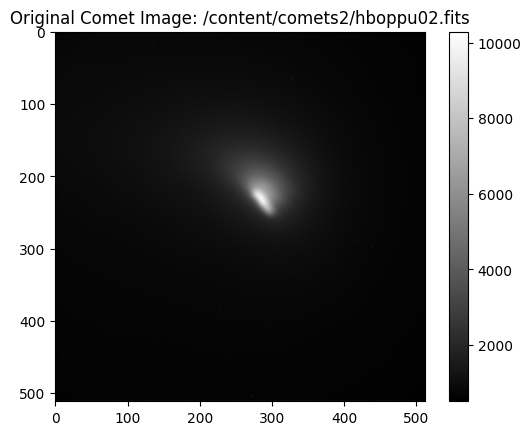

--------------------------------------------
Centroid: (237.43, 251.95), Peak Intensity: 1778
--------------------------------------------


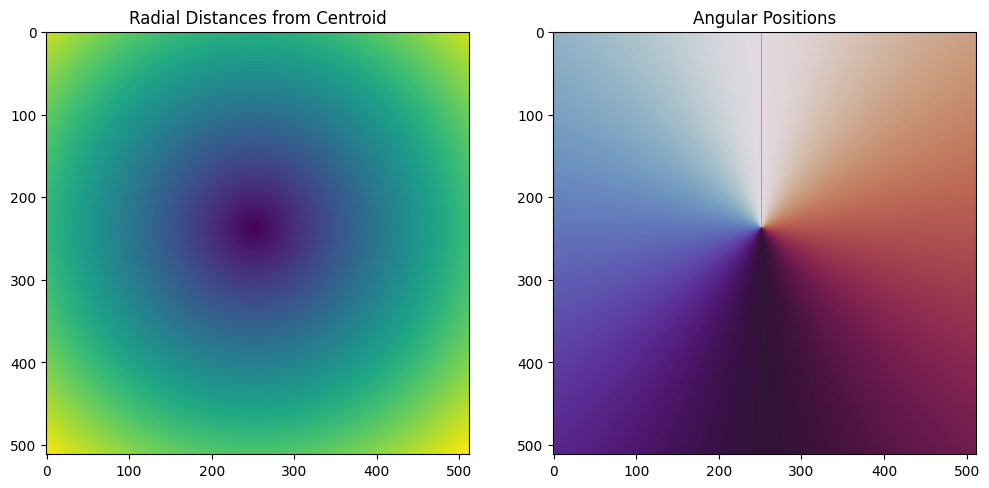

Bin 0: Alpha = 0.0030798339954171633
Bin 1: Alpha = 0.0026808835945707305
Bin 2: Alpha = 0.003581907488930354
Bin 3: Alpha = 0.003718525929784838
Bin 4: Alpha = 0.0041502986747452885
Bin 5: Alpha = 0.004173469856403572
Bin 6: Alpha = 0.003791392922925032
Bin 7: Alpha = 0.0038978360174008646
Bin 8: Alpha = 0.0035050535514512537
Bin 9: Alpha = 0.0034246018939442326
Cosine Fit Params: A = 0.0005017045559675415, theta0 = 0.02655658139733574


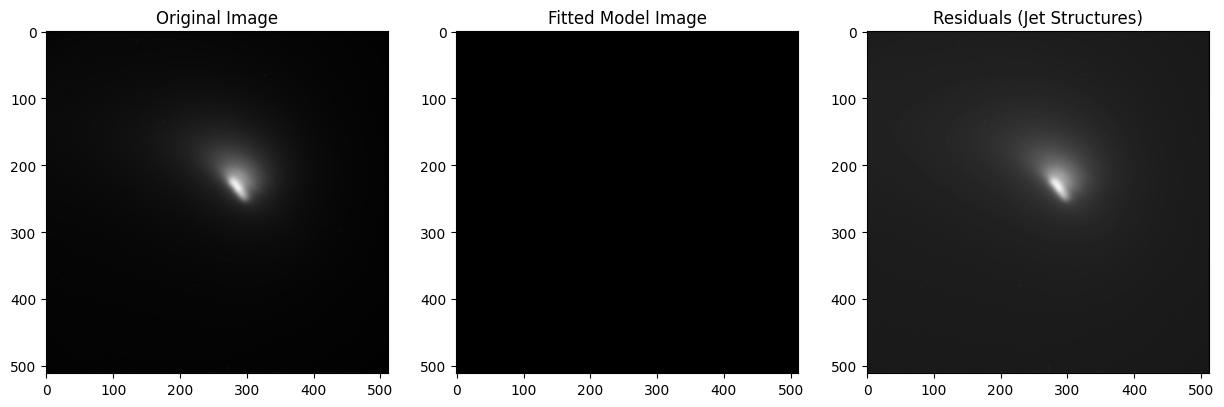

----------------------------------------------------------------
Model Parameters for hboppu02.fits: [0.0005017  0.02655658]
----------------------------------------------------------------


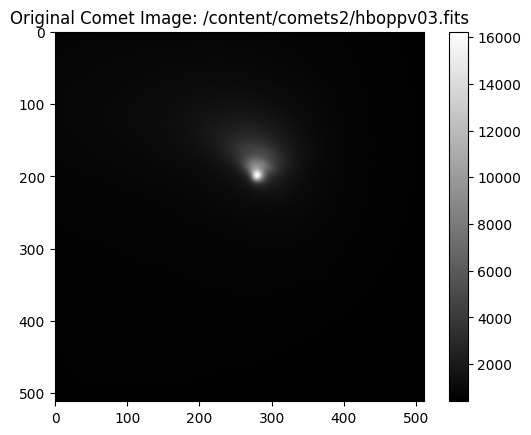

--------------------------------------------
Centroid: (223.94, 250.13), Peak Intensity: 1131
--------------------------------------------


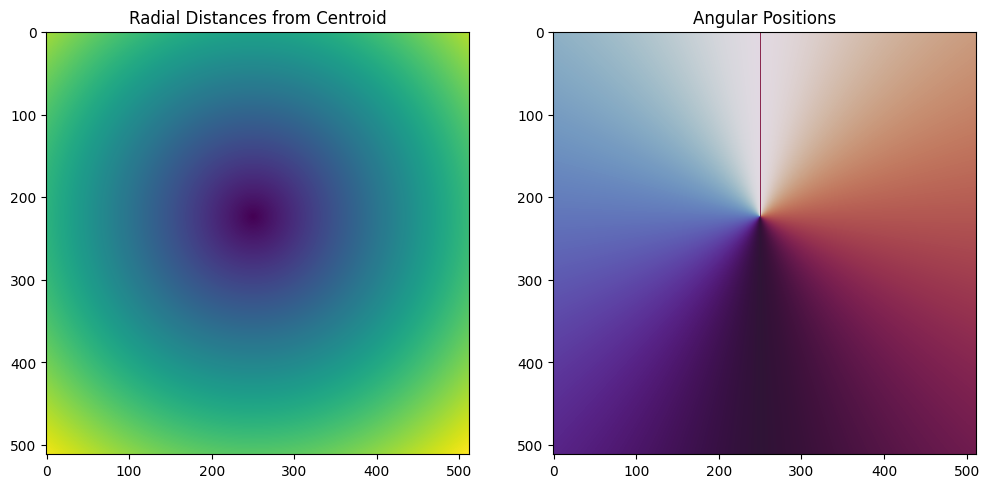

Bin 0: Alpha = 0.0007479183794755496
Bin 1: Alpha = 0.0012641195629515146
Bin 2: Alpha = 0.002556116466116953
Bin 3: Alpha = 0.002790786022499884
Bin 4: Alpha = 0.003038333533757272
Bin 5: Alpha = 0.003132550326016687
Bin 6: Alpha = 0.0029068203354803246
Bin 7: Alpha = 0.003061231532757781
Bin 8: Alpha = 0.0023207359329294837
Bin 9: Alpha = 0.0011379457187614163
Cosine Fit Params: A = 0.0011134808920482365, theta0 = 17.50737978928861


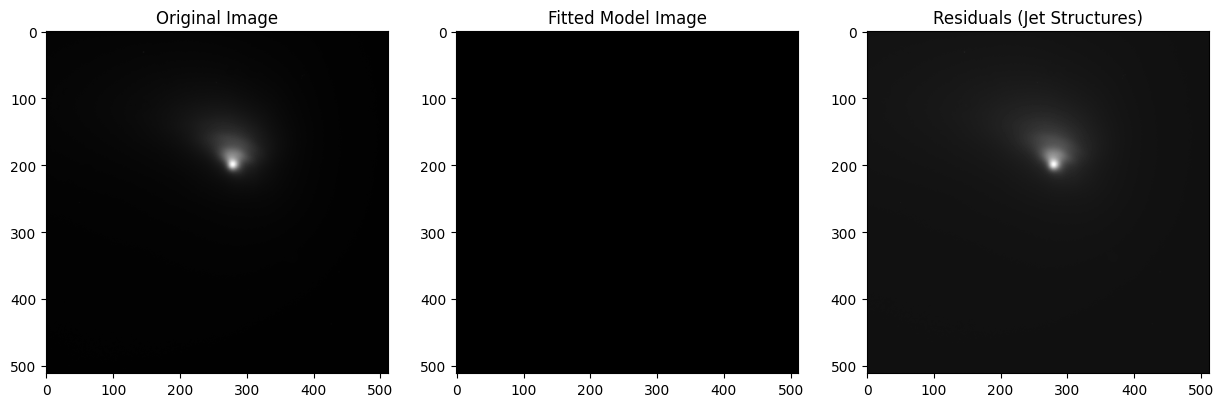

----------------------------------------------------------------
Model Parameters for hboppv03.fits: [1.11348089e-03 1.75073798e+01]
----------------------------------------------------------------


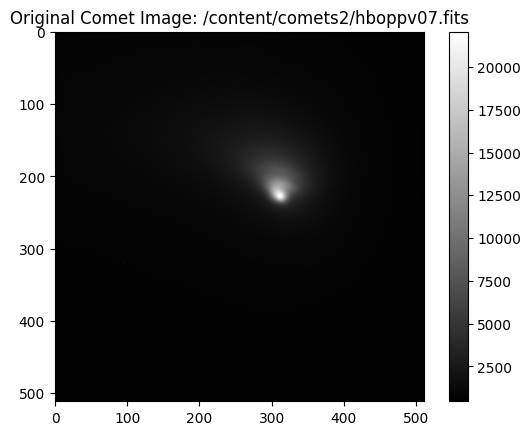

--------------------------------------------
Centroid: (224.13, 258.04), Peak Intensity: 1880
--------------------------------------------


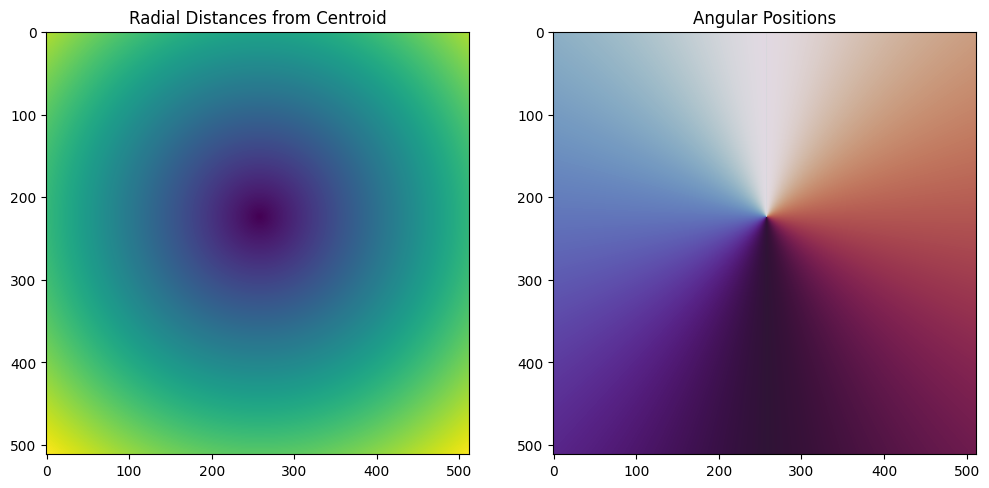

Bin 0: Alpha = 0.002858954030372997
Bin 1: Alpha = 0.002613394167863214
Bin 2: Alpha = 0.003670305825880693
Bin 3: Alpha = 0.004130144287306909
Bin 4: Alpha = 0.004562192916546299
Bin 5: Alpha = 0.0045951477630037174
Bin 6: Alpha = 0.004228986404125836
Bin 7: Alpha = 0.003867905039756923
Bin 8: Alpha = 0.003576111072054861
Bin 9: Alpha = 0.003175614934712444
Cosine Fit Params: A = 0.0008490447864627493, theta0 = 0.02676533622563629


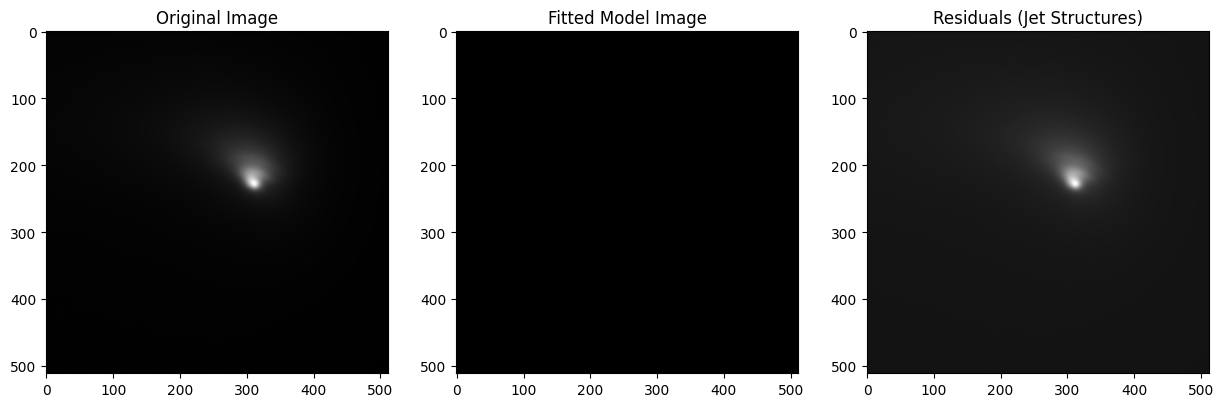

----------------------------------------------------------------
Model Parameters for hboppv07.fits: [0.00084904 0.02676534]
----------------------------------------------------------------


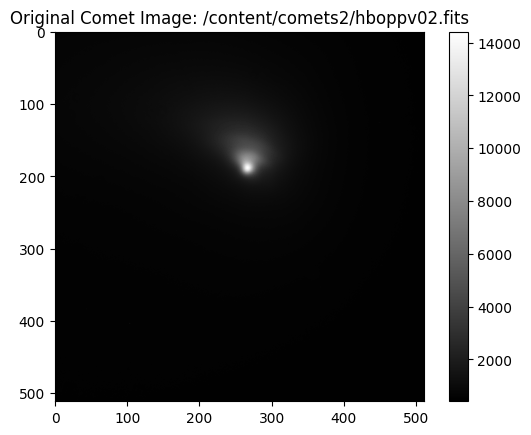

--------------------------------------------
Centroid: (223.09, 246.94), Peak Intensity: 1028
--------------------------------------------


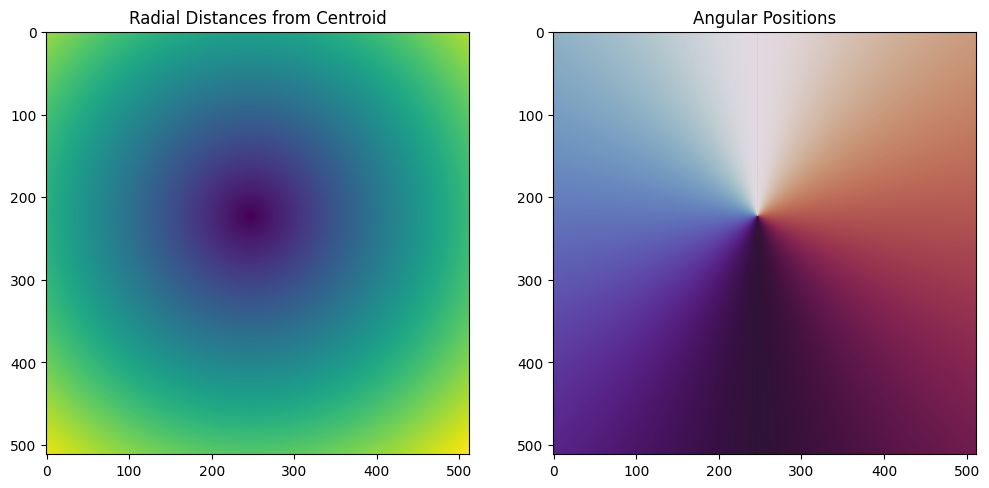

Bin 0: Alpha = 4.875773983713022e-05
Bin 1: Alpha = 0.0008455163705826611
Bin 2: Alpha = 0.002256199782308109
Bin 3: Alpha = 0.002485697507725826
Bin 4: Alpha = 0.002696772975662165
Bin 5: Alpha = 0.0028052868232427658
Bin 6: Alpha = 0.0026048479084194356
Bin 7: Alpha = 0.0028383764986901535
Bin 8: Alpha = 0.002146393497456325
Bin 9: Alpha = 0.0006036978698113813
Cosine Fit Params: A = 0.0012284465877710911, theta0 = 18.32752887049049


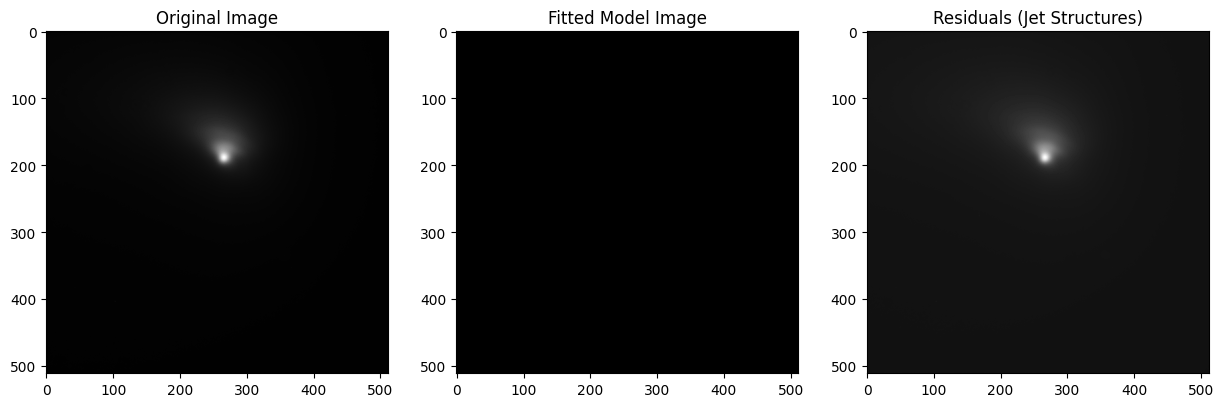

----------------------------------------------------------------
Model Parameters for hboppv02.fits: [1.22844659e-03 1.83275289e+01]
----------------------------------------------------------------


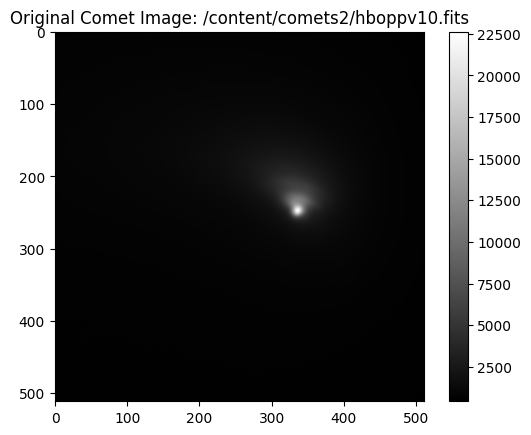

--------------------------------------------
Centroid: (234.41, 265.29), Peak Intensity: 1546
--------------------------------------------


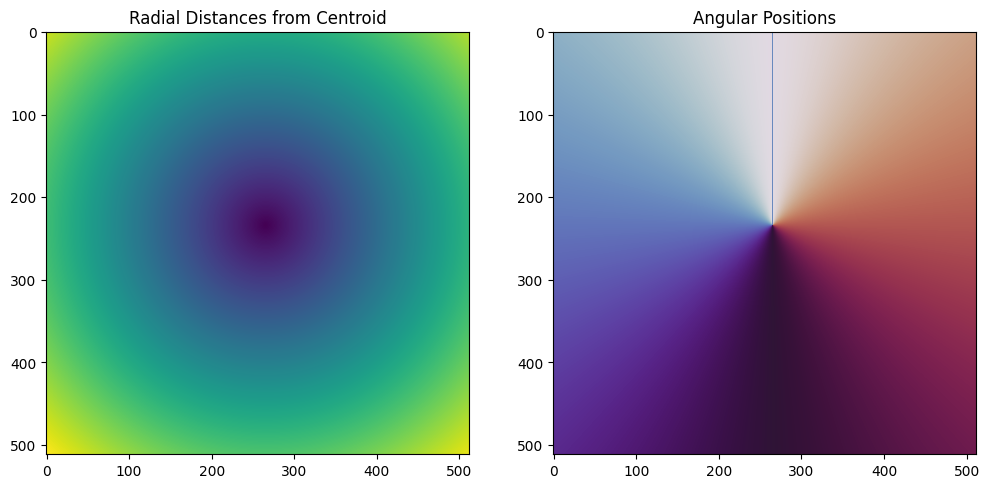

Bin 0: Alpha = 0.0028097518528431053
Bin 1: Alpha = 0.0023994939561551515
Bin 2: Alpha = 0.0030724258407919987
Bin 3: Alpha = 0.003497905815754523
Bin 4: Alpha = 0.003995660475273214
Bin 5: Alpha = 0.003933128331258465
Bin 6: Alpha = 0.0034515428473599246
Bin 7: Alpha = 0.002397060000329826
Bin 8: Alpha = 0.0028823708021069564
Bin 9: Alpha = 0.0029535420475809157
Cosine Fit Params: A = 0.000607941253597033, theta0 = -0.0067312304851215735


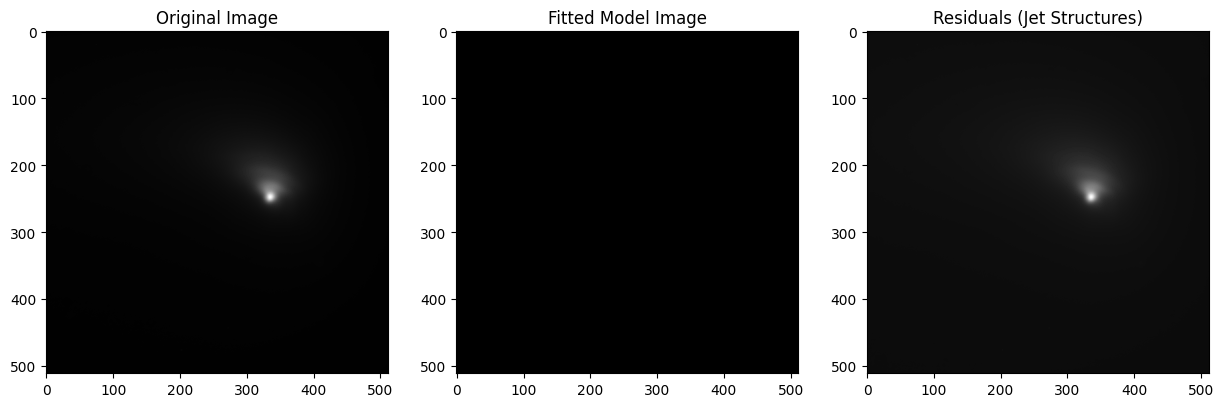

----------------------------------------------------------------
Model Parameters for hboppv10.fits: [ 0.00060794 -0.00673123]
----------------------------------------------------------------


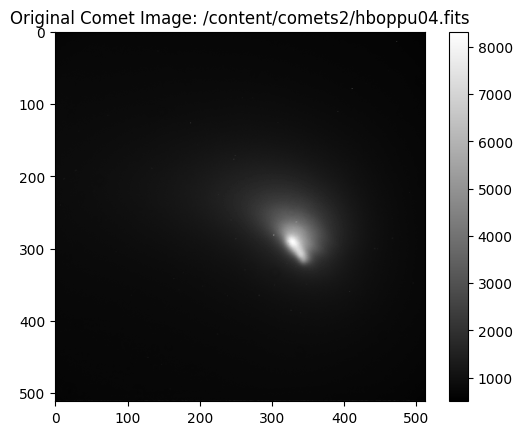

--------------------------------------------
Centroid: (255.91, 262.83), Peak Intensity: 1832
--------------------------------------------


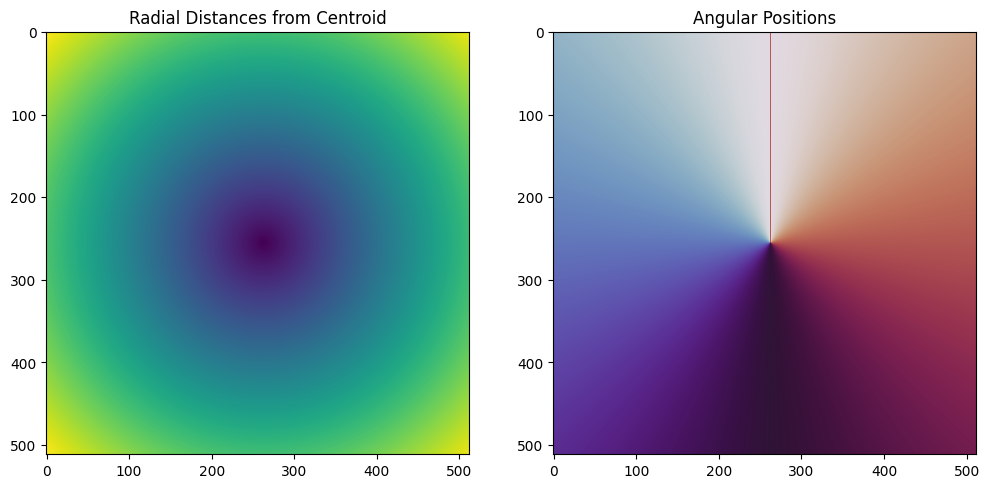

Bin 0: Alpha = 0.0038560194602298026
Bin 1: Alpha = 0.0031568236804788733
Bin 2: Alpha = 0.0034375243799876602
Bin 3: Alpha = 0.00356916847884686
Bin 4: Alpha = 0.004133834607046777
Bin 5: Alpha = 0.003858641048707083
Bin 6: Alpha = 0.0030994023428625927
Bin 7: Alpha = 0.0030457667879151846
Bin 8: Alpha = 0.0035750435312851313
Bin 9: Alpha = 0.003987480005953349
Cosine Fit Params: A = 1.6322886442839495e-05, theta0 = -57.30426673063681


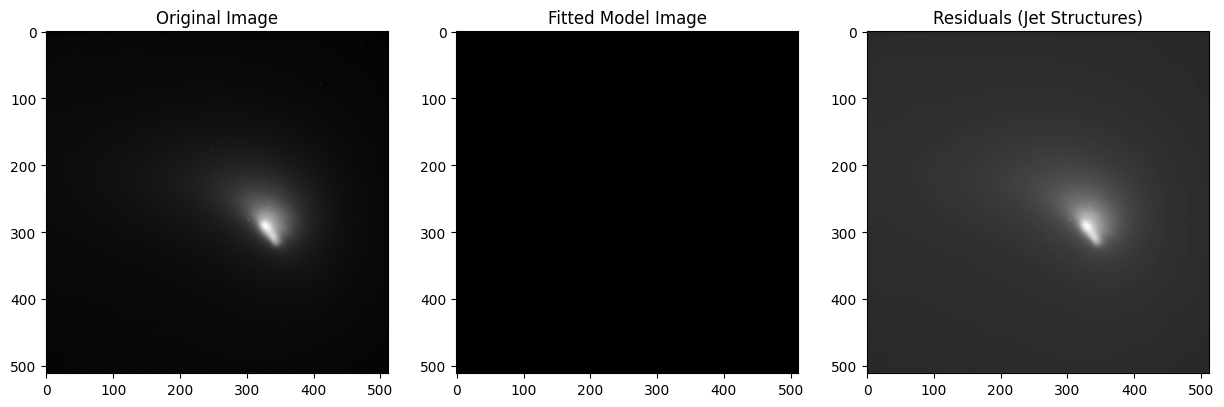

----------------------------------------------------------------
Model Parameters for hboppu04.fits: [ 1.63228864e-05 -5.73042667e+01]
----------------------------------------------------------------


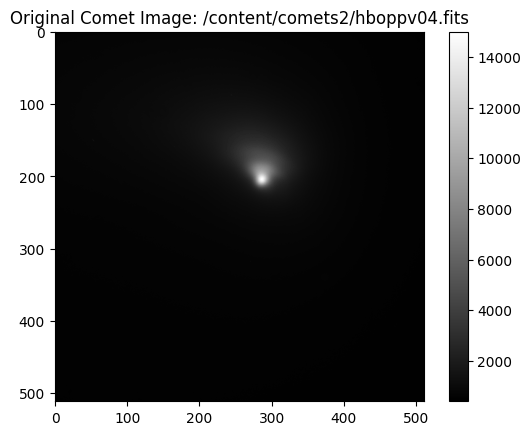

--------------------------------------------
Centroid: (225.00, 251.57), Peak Intensity: 1181
--------------------------------------------


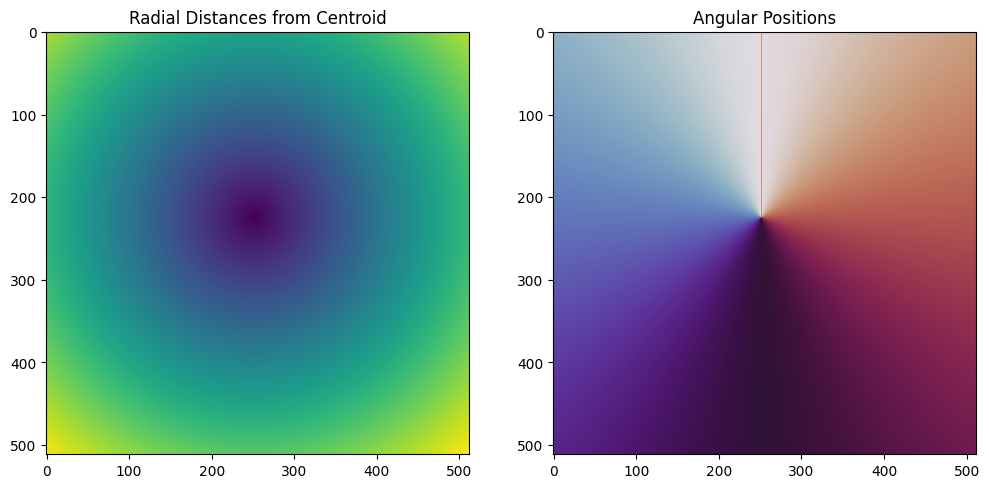

Bin 0: Alpha = 0.001098194448257428
Bin 1: Alpha = 0.0014504718047989116
Bin 2: Alpha = 0.0026931750840816617
Bin 3: Alpha = 0.0029327197154906844
Bin 4: Alpha = 0.0032026328333115382
Bin 5: Alpha = 0.0032848223073418045
Bin 6: Alpha = 0.0030386887642982604
Bin 7: Alpha = 0.003132036378405167
Bin 8: Alpha = 0.0024172239305000976
Bin 9: Alpha = 0.0014477168630746707
Cosine Fit Params: A = 0.0010189693523805364, theta0 = 15.511446164266598


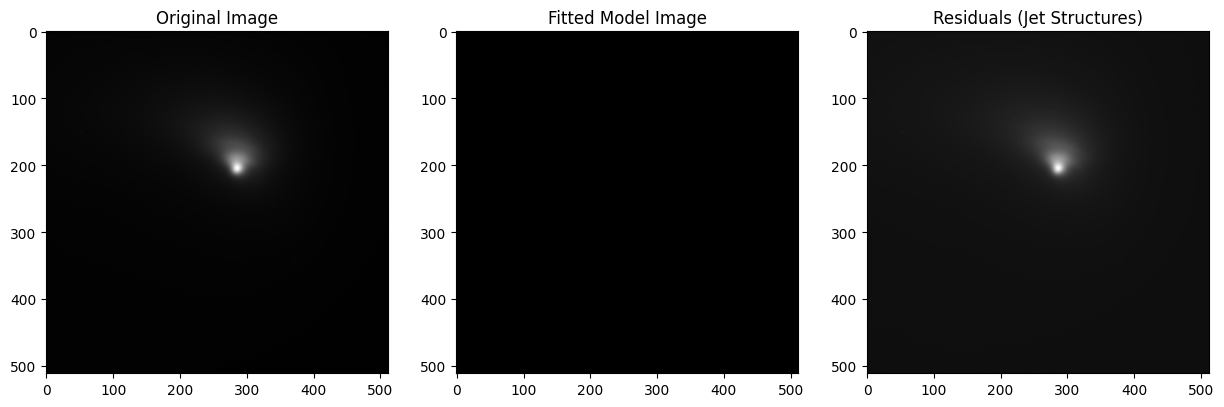

----------------------------------------------------------------
Model Parameters for hboppv04.fits: [1.01896935e-03 1.55114462e+01]
----------------------------------------------------------------


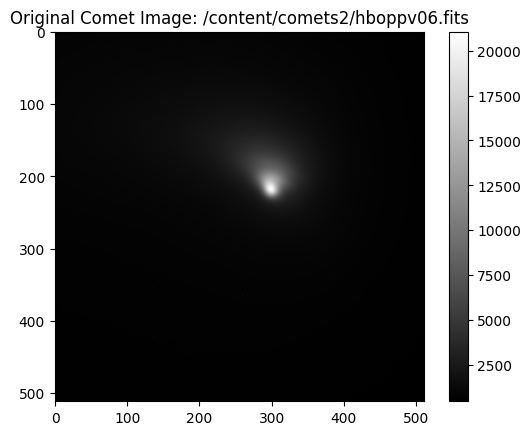

--------------------------------------------
Centroid: (220.83, 254.21), Peak Intensity: 1911
--------------------------------------------


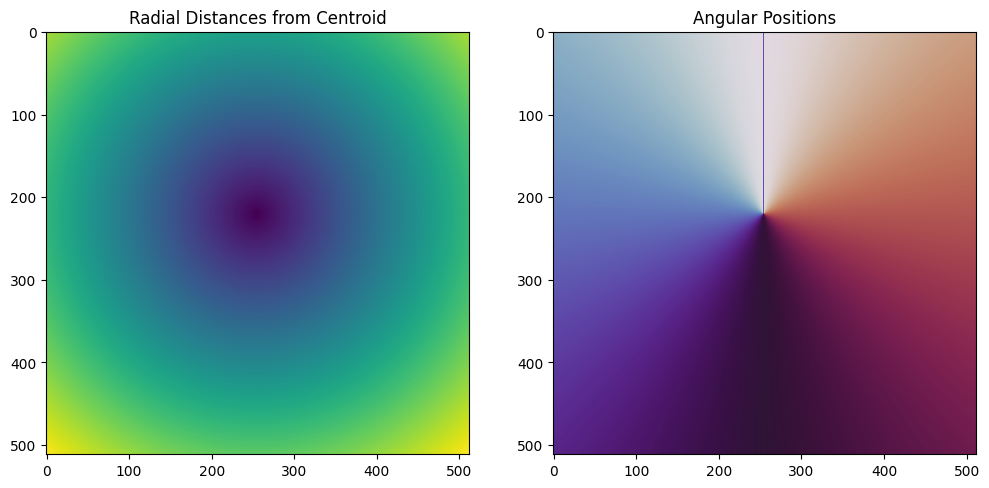

Bin 0: Alpha = 0.002687206231974924
Bin 1: Alpha = 0.0025519014217173413
Bin 2: Alpha = 0.003815684816948455
Bin 3: Alpha = 0.004248326438121141
Bin 4: Alpha = 0.004626970683837093
Bin 5: Alpha = 0.004695846392778558
Bin 6: Alpha = 0.0043609465226996874
Bin 7: Alpha = 0.0042817899866249304
Bin 8: Alpha = 0.0037470887761677884
Bin 9: Alpha = 0.003124657266753798
Cosine Fit Params: A = 0.0009940601703183787, theta0 = 20.4065177658275


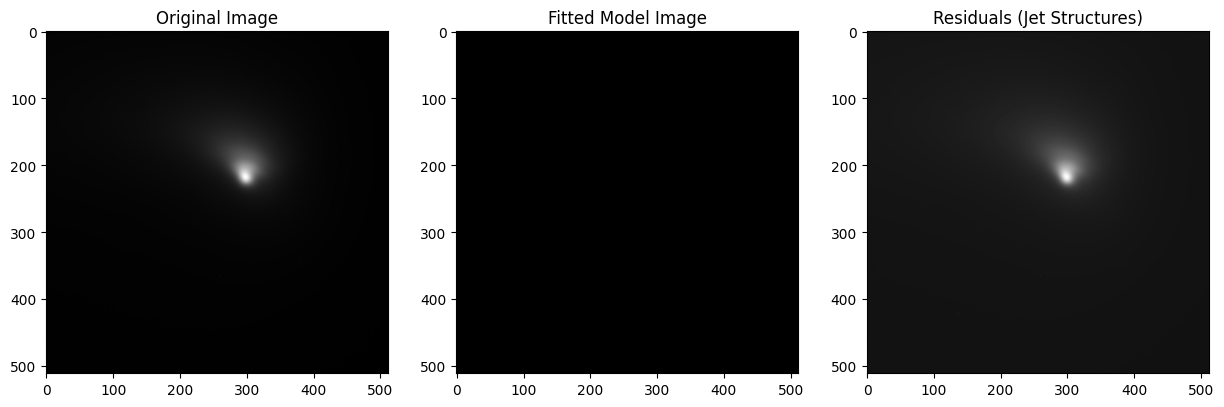

----------------------------------------------------------------
Model Parameters for hboppv06.fits: [9.94060170e-04 2.04065178e+01]
----------------------------------------------------------------


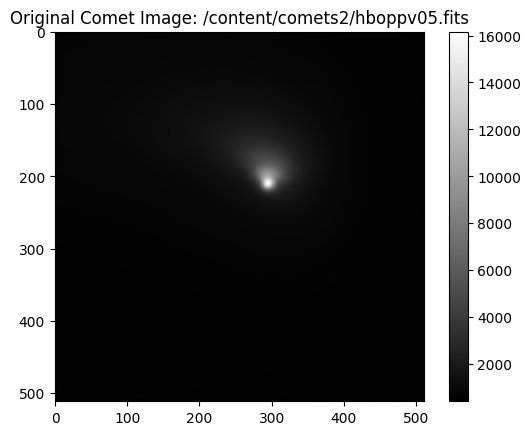

--------------------------------------------
Centroid: (225.39, 253.49), Peak Intensity: 1217
--------------------------------------------


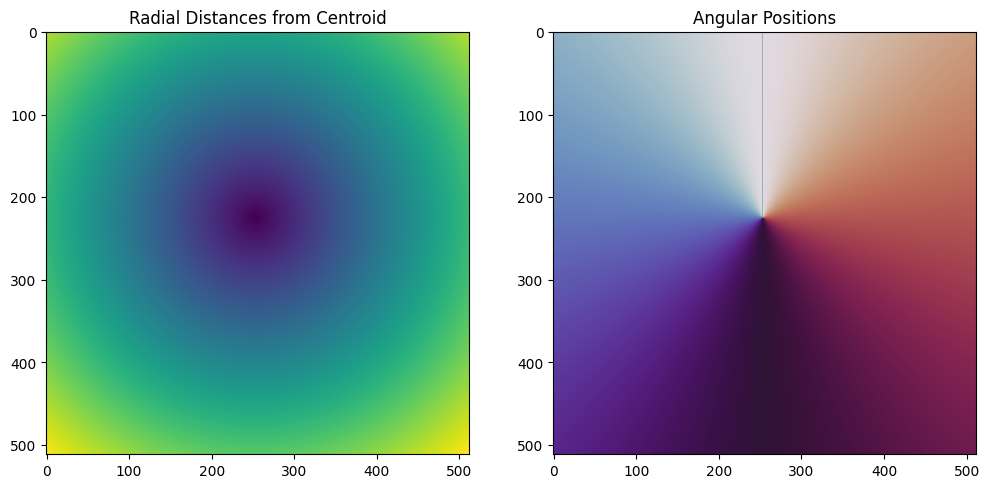

Bin 0: Alpha = 0.0012865505798054654
Bin 1: Alpha = 0.0015091709094941317
Bin 2: Alpha = 0.002668336464986218
Bin 3: Alpha = 0.0029779402699501643
Bin 4: Alpha = 0.0032686069947310153
Bin 5: Alpha = 0.003336882639197086
Bin 6: Alpha = 0.0030813516925322863
Bin 7: Alpha = 0.0030278216270463697
Bin 8: Alpha = 0.0023949207967710875
Bin 9: Alpha = 0.0015744278558840683
Cosine Fit Params: A = 0.000965610898063185, theta0 = 0.029179540099714147


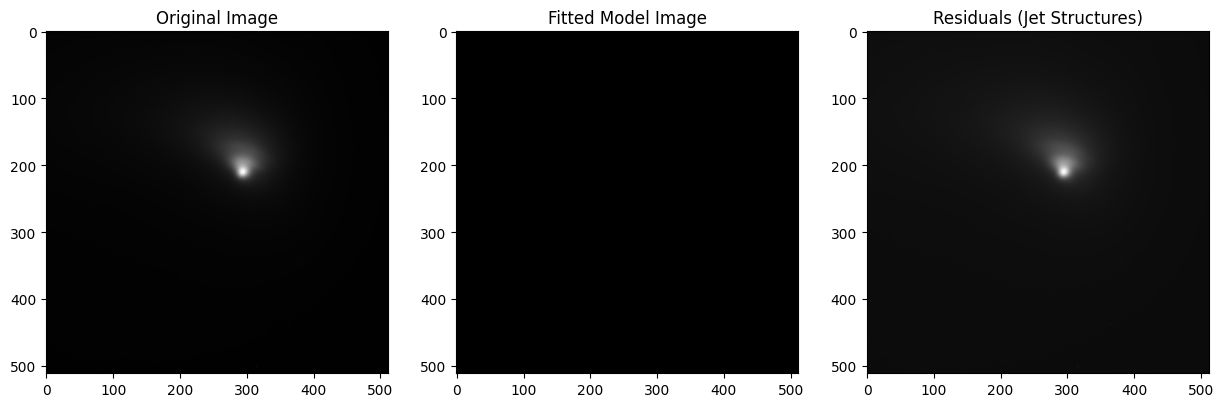

----------------------------------------------------------------
Model Parameters for hboppv05.fits: [0.00096561 0.02917954]
----------------------------------------------------------------


In [32]:
def process_all_fits(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".fits"):
            fits_path = os.path.join(directory, filename)
            image_data, x0, y0, I0, rho, theta, T1 = process_fits(fits_path)
            model_image, residuals, params = fit_model(T1, I0, image_data)

            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image_data, cmap='gray')
            ax[0].set_title('Original Image')
            ax[1].imshow(model_image, cmap='gray')
            ax[1].set_title('Fitted Model Image')
            ax[2].imshow(residuals, cmap='gray')
            ax[2].set_title('Residuals (Jet Structures)')
            plt.show()

            print(f"----------------------------------------------------------------")
            print(f"Model Parameters for {filename}: {params}")
            print(f"----------------------------------------------------------------")

# Example usage: process all FITS files in a directory
process_all_fits('/content/comets2')
